In [1]:
import torch
import pandas as pd
import numpy as np
import requests
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
import matplotlib.pyplot as plt

# Ustawienie urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/karotka/sem10/cuda/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ładowanie modelu do embeddingów
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)


In [3]:
def get_embeddings(texts: List[str], tokenizer, model):
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    token_embeddings = outputs.last_hidden_state
    embeddings = torch.mean(token_embeddings, dim=1)
    return embeddings.cpu().numpy()


In [4]:
puzzles_df = pd.read_csv('puzzles_dataset.csv')

puzzles_texts = puzzles_df['puzzle'].tolist()
puzzles_answers = puzzles_df['answer'].tolist()
puzzles_difficulties = puzzles_df['difficulty'].tolist()


In [7]:
# Obliczenie embeddingów dla bazy zagadek
puzzles_embeddings = get_embeddings(puzzles_texts, tokenizer, model)

In [5]:
class ReasoningFewShotAgent:
    def __init__(self, tokenizer, model, db_texts, db_answers, db_embeddings, ollama_model="mistral", ollama_endpoint="http://localhost:11434"):
        self.tokenizer = tokenizer
        self.model = model
        self.db_texts = db_texts
        self.db_answers = db_answers
        self.db_embeddings = db_embeddings
        self.ollama_model = ollama_model
        self.ollama_endpoint = ollama_endpoint

    def get_query_embedding(self, query: str):
        return get_embeddings([query], self.tokenizer, self.model)[0]

    def retrieve_examples(self, query_embedding, top_k=3):
        similarities = cosine_similarity([query_embedding], self.db_embeddings)[0]
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        examples = [(self.db_texts[i], self.db_answers[i]) for i in top_indices]
        return examples

    def build_prompt(self, examples, query):
        prompt = (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku.\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            "Przykłady:\n"
        )
        for i, (ex_question, ex_answer) in enumerate(examples):
            prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
        prompt += f"Nowa zagadka:\n{query}\n"
        return prompt


    def query_ollama(self, prompt):
        response = requests.post(
            f"{self.ollama_endpoint}/api/generate",
            json={
                "model": self.ollama_model,
                "prompt": prompt,
                "stream": False
            }
        )

        if response.status_code != 200:
            raise Exception(f"Błąd komunikacji z Ollama: {response.status_code} {response.text}")

        return response.json().get('response', '').strip()

    def solve(self, query: str, top_k=3, verbose: bool = True):
        query_embedding = self.get_query_embedding(query)
        examples = self.retrieve_examples(query_embedding, top_k=top_k)
        prompt = self.build_prompt(examples, query)
        response = self.query_ollama(prompt)

        if verbose:
            print("🧠 Symulacja rozumowania agenta:\n")
            print(response)

        return response


In [8]:
# Inicjalizacja ReasoningFewShotAgenta
agent = ReasoningFewShotAgent(
    tokenizer=tokenizer,
    model=model,
    db_texts=puzzles_texts,
    db_answers=puzzles_answers,
    db_embeddings=puzzles_embeddings,
    ollama_model="mistral"
)

# Test na nowej zagadce
query = "Ala ma więcej cukierków niż Ola. Ola ma więcej niż Ela. Kto ma najwięcej cukierków?"
agent.solve(query, top_k=3, verbose=True)


🧠 Symulacja rozumowania agenta:

Odpowiedź: Ala


'Odpowiedź: Ala'

In [10]:
import re
from collections import defaultdict

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip().lower()
    text = text.replace("odpowiedź", "").strip()
    return text

def evaluate_answers(agent, test_queries, test_answers, verbose) -> tuple:
    correct = 0
    for query, answer in zip(test_queries, test_answers):
        answer = normalize_text(answer.strip())
        if verbose:
            print(f'\n\nQuery is: {query}\t Correct answer is: {answer}')
        response = normalize_text(agent.solve(query, top_k=3, verbose = verbose).strip())
        if response == answer:
            print("Answer was correct :)")
            correct += 1
        else:
            print(f'Response:[{response}] vs answer[{answer}]')
    return correct, len(test_queries) - correct

def evaluate_agent_by_category(agent, puzzles_df, verbose = True):
    difficulties = puzzles_df['difficulty'].unique()
    
    accuracy_score = defaultdict(lambda: (int, int))
    for difficulty in difficulties:
        print(f"Processing difficulty: {difficulty}")
        category_rows = puzzles_df[puzzles_df['difficulty'] == difficulty]
        
        test_queries = category_rows["puzzle"].tolist()
        test_answers = category_rows["answer"].tolist()
        accuracy_score[difficulty] = evaluate_answers(agent, test_queries, test_answers, verbose)
        
    return accuracy_score
    
accuracies = evaluate_agent_by_category(agent, puzzles_df)

Processing difficulty: easy


Query is: Anna ma więcej jabłek niż Basia. Basia ma więcej niż Celina. Kto ma najwięcej jabłek?	 Correct answer is: anna
🧠 Symulacja rozumowania agenta:

Anna
Answer was correct :)


Query is: Tomek jest młodszy od Michała, ale starszy od Piotra. Kto jest najstarszy?	 Correct answer is: michał
🧠 Symulacja rozumowania agenta:

Odpowiedź: Michał
Answer was correct :)


Query is: Która liczba jest większa: 35 czy 53?	 Correct answer is: 53
🧠 Symulacja rozumowania agenta:

Odpowiedź: 53
Answer was correct :)


Query is: Pies waży więcej niż kot, ale mniej niż koń. Które zwierzę jest najcięższe?	 Correct answer is: koń
🧠 Symulacja rozumowania agenta:

Odpowiedź: koń
Answer was correct :)


Query is: Jeśli dzisiaj jest wtorek, jaki dzień będzie za trzy dni?	 Correct answer is: piątek
🧠 Symulacja rozumowania agenta:

Odpowiedź: piątek
Answer was correct :)


Query is: Mama Adama ma trzech synów: Kwiatek, Motylek i...?	 Correct answer is: adam
🧠 Symulacja rozumowa

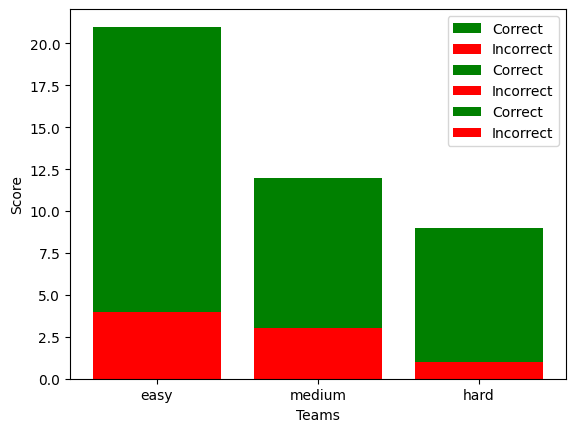

In [11]:
import matplotlib.pyplot as plt

def plot_accuracies(acc_dict: dict):
    i = 1
    for diff in acc_dict.keys():
        plt.bar(diff, acc_dict[diff][0], width = 0.8, color='g', label='Correct')
        plt.bar(diff, acc_dict[diff][1], width = 0.8, color='r', label='Incorrect')
        
    plt.xlabel("Teams")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
plot_accuracies(accuracies)

## Few shot strategies

In [19]:
class ChainOfThoughtAgent(ReasoningFewShotAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def build_prompt(self, examples, query):
        prompt = (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku, pokazując swoje rozumowanie.\n\n"
            "Ważne:\n"
            "1. Najpierw przeanalizuj problem dokładnie\n"
            "2. Rozbij problem na mniejsze kroki\n"
            "3. Rozwiąż każdy krok osobno\n"
            "4. Wyciągnij ostateczny wniosek\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            "Przykłady:\n"
        )
        
        for i, (ex_question, ex_answer) in enumerate(examples):
            prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
        
        prompt += f"Nowa zagadka:\n{query}\n\nKrok po kroku rozumowanie:\n"
        return prompt

In [45]:
class FewShotStrategies:
    @staticmethod
    def most_similar(query_embedding, db_embeddings, db_texts, db_answers, top_k=3):
        """Standard similarity-based selection (what you already have)"""
        similarities = cosine_similarity([query_embedding], db_embeddings)[0]
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        return [(db_texts[i], db_answers[i]) for i in top_indices]
    
    @staticmethod
    def diverse_sampling(query_embedding, db_embeddings, db_texts, db_answers, top_k=3, diversity_factor=0.5):
        """Select diverse examples while maintaining relevance"""
        similarities = cosine_similarity([query_embedding], db_embeddings)[0]
        
        selected_indices = [np.argmax(similarities)]
        selected_embeddings = [db_embeddings[selected_indices[0]]]
        
        remaining_indices = list(set(range(len(db_embeddings))) - set(selected_indices))
        
        while len(selected_indices) < top_k and remaining_indices:
            sim_to_query = similarities[remaining_indices]
            
            sim_to_selected = cosine_similarity(
                db_embeddings[remaining_indices],
                np.array(selected_embeddings)
            )
            avg_sim_to_selected = np.mean(sim_to_selected, axis=1)
            
            combined_score = diversity_factor * sim_to_query - (1 - diversity_factor) * avg_sim_to_selected
 
            best_idx_pos = np.argmax(combined_score)
            best_idx = remaining_indices[best_idx_pos]
            

            selected_indices.append(best_idx)
            selected_embeddings.append(db_embeddings[best_idx])
            remaining_indices.remove(best_idx)
        
        return [(db_texts[i], db_answers[i]) for i in selected_indices]
    
    @staticmethod
    def difficulty_based(query_embedding, db_embeddings, db_texts, db_answers, difficulties, top_k=3, target_difficulty=None):
        """Select examples of similar difficulty level"""
        if target_difficulty is None:

            similarities = cosine_similarity([query_embedding], db_embeddings)[0]
            top_indices = np.argsort(similarities)[-5:][::-1]  # Use top 5 to vote
            difficulty_counts = {}
            for idx in top_indices:
                diff = difficulties[idx]
                difficulty_counts[diff] = difficulty_counts.get(diff, 0) + 1
            target_difficulty = max(difficulty_counts.items(), key=lambda x: x[1])[0]
        

        target_indices = [i for i, d in enumerate(difficulties) if d == target_difficulty]
        

        similarities = cosine_similarity([query_embedding], db_embeddings[target_indices])[0]

        top_k_indices = np.argsort(similarities)[-top_k:][::-1]
        selected_indices = [target_indices[i] for i in top_k_indices]
        
        return [(db_texts[i], db_answers[i]) for i in selected_indices]

In [20]:
def create_cot_examples(agent, puzzles_df, num_examples=5):
    """Generate chain-of-thought examples using the base agent"""
    cot_examples = []
    
    for difficulty in puzzles_df['difficulty'].unique():
        category_rows = puzzles_df[puzzles_df['difficulty'] == difficulty].sample(min(2, sum(puzzles_df['difficulty'] == difficulty)))
        
        for _, row in category_rows.iterrows():
            query = row['puzzle']
            answer = row['answer']

            reasoning = agent.solve(query, verbose=False)
            

            if not reasoning.strip().endswith(answer):
                reasoning += f"\nOdpowiedź: {answer}"
                
            cot_examples.append((query, reasoning))
            
            if len(cot_examples) >= num_examples:
                break
                
    return cot_examples

In [33]:
class EnhancedReasoningAgent(ReasoningFewShotAgent):
    def __init__(self, *args, use_chain_of_thought=False, few_shot_strategy="most_similar", 
                 strategy_params=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_chain_of_thought = use_chain_of_thought
        self.few_shot_strategy = few_shot_strategy
        self.strategy_params = strategy_params or {}
        
    def retrieve_examples(self, query_embedding, top_k=3):
        if self.few_shot_strategy == "most_similar":
            return FewShotStrategies.most_similar(
                query_embedding, self.db_embeddings, self.db_texts, self.db_answers, top_k)
        elif self.few_shot_strategy == "diverse":
            diversity_factor = self.strategy_params.get("diversity_factor", 0.5)
            return FewShotStrategies.diverse_sampling(
                query_embedding, self.db_embeddings, self.db_texts, self.db_answers, 
                top_k, diversity_factor)
        elif self.few_shot_strategy == "difficulty_based":
            difficulties = self.strategy_params.get("difficulties", [])
            target_difficulty = self.strategy_params.get("target_difficulty", None)
            return FewShotStrategies.difficulty_based(
                query_embedding, self.db_embeddings, self.db_texts, self.db_answers, 
                difficulties, top_k, target_difficulty)
        else:
            return super().retrieve_examples(query_embedding, top_k)
            
    def build_prompt(self, examples, query):
        if self.use_chain_of_thought:
            # Chain of thought prompt
            prompt = (
                "Jesteś agentem rozwiązującym zagadki logiczne.\n"
                "Twoim zadaniem jest rozwiązać zagadkę krok po kroku, pokazując swoje rozumowanie.\n\n"
                "Ważne:\n"
                "1. Najpierw przeanalizuj problem dokładnie\n"
                "2. Rozbij problem na mniejsze kroki\n"
                "3. Rozwiąż każdy krok osobno\n"
                "4. Wyciągnij ostateczny wniosek\n\n"
                "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
                "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
                "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
                "Przykłady:\n"
            )
            
            for i, (ex_question, ex_answer) in enumerate(examples):
                prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
            
            prompt += f"Nowa zagadka:\n{query}\n\nKrok po kroku rozumowanie:\n"
        else:
            return super().build_prompt(examples, query)
            
        return prompt

In [22]:
def compare_agent_strategies(puzzles_df, tokenizer, model, puzzles_embeddings, verbose=False):
    from sklearn.model_selection import train_test_split
    
    train_df, test_df = train_test_split(puzzles_df, test_size=0.2, random_state=42)
    
    train_texts = train_df['puzzle'].tolist()
    train_answers = train_df['answer'].tolist()
    train_embeddings = get_embeddings(train_texts, tokenizer, model)
    
    test_queries = test_df["puzzle"].tolist()
    test_answers = test_df["answer"].tolist()

    base_agent = ReasoningFewShotAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral"
    )
    

    cot_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        use_chain_of_thought=True
    )
    

    diverse_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        few_shot_strategy="diverse",
        strategy_params={"diversity_factor": 0.7}
    )
    
    difficulty_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        few_shot_strategy="difficulty_based",
        strategy_params={"difficulties": train_df['difficulty'].tolist()}
    )
    

    combined_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        use_chain_of_thought=True,
        few_shot_strategy="diverse",
        strategy_params={"diversity_factor": 0.7}
    )
    
    agents = {
        "Base Agent": base_agent,
        "Chain of Thought": cot_agent, 
        "Diverse Examples": diverse_agent,
        "Difficulty-Based": difficulty_agent,
        "Combined Approach": combined_agent
    }
    
    results = {}
    
    test_subset = test_queries[:min(15, len(test_queries))]
    test_answers_subset = test_answers[:min(15, len(test_answers))]
    
    for name, agent in agents.items():
        print(f"\nEvaluating {name}...")
        correct, incorrect = evaluate_answers(agent, test_subset, test_answers_subset, verbose)
        results[name] = (correct, incorrect)
    
    return results

def plot_comparison_results(results):
    """Plot comparative results of different strategies"""
    agent_names = list(results.keys())
    correct = [results[name][0] for name in agent_names]
    total = [results[name][0] + results[name][1] for name in agent_names]
    accuracy = [100 * results[name][0] / (results[name][0] + results[name][1]) for name in agent_names]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(agent_names, accuracy, color='skyblue')
    
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f"{accuracy[i]:.1f}%\n({correct[i]}/{total[i]})", 
                ha='center', va='bottom')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Comparison of Different Reasoning Strategies')
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

Chain of Thought reasoning with diverse examples:
🧠 Symulacja rozumowania agenta:

1. Analizujemy problem: 5 kotów łapią 5 myszy w 5 minut (stosunek 1:1), to oznacza, że każdy kot złapie jedną mysz w ciągu minuty.

  2. Rozbijamy problem na mniejsze kroki: w 15 minut 3 razy więcej czasu niż w 5 minutach, a także 3 razy większa liczba kotów. Zatem złapie trzy razy więcej myszy każdy z 15 kotów.

  3. Rozwiązujemy każdy krok osobno: w ciągu jednej minuty po 15 kotach zostanie złapanych 15 myszy (bo każdy kot złapie jedną mysz), a w ciągu 15 minut 15 myszy po 15 kotach (bo 3 razy więcej czasu i 3 razy większa liczba kotów).

  4. Wyciągamy ostateczny wniosek: Ile myszy złapie 15 kotów w 15 minut? Odpowiedź: 15 * 15 = 225 myszy.

Comparing different strategies...

Evaluating Base Agent...
Answer was correct :)
Response:[basia zapłaciła 6 zł] vs answer[6]
Response:[12] vs answer[7]
Response:[56 jest większa od 34] vs answer[56]

Evaluating Chain of Thought...
Response:[1 przeanalizuj proble

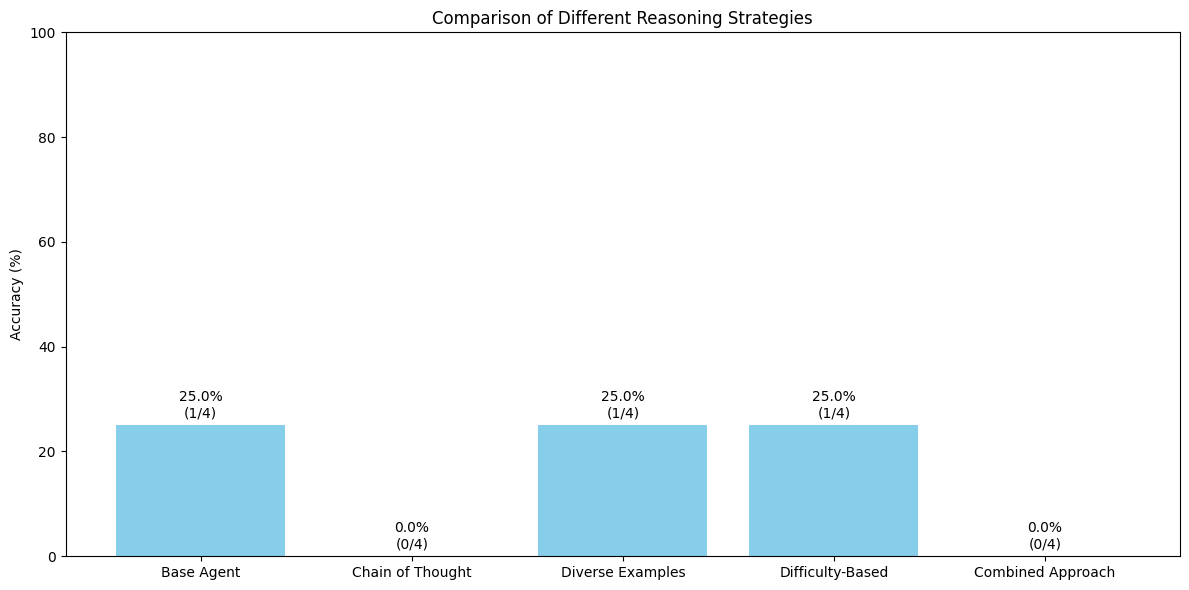

In [ ]:

enhanced_agent = EnhancedReasoningAgent(
    tokenizer=tokenizer,
    model=model,
    db_texts=puzzles_texts,
    db_answers=puzzles_answers,
    db_embeddings=puzzles_embeddings,
    ollama_model="mistral",
    use_chain_of_thought=True,
    few_shot_strategy="diverse",
    strategy_params={"diversity_factor": 0.7}
)

test_query = "Jeśli 5 kotów łapie 5 myszy w 5 minut, ile myszy złapie 15 kotów w 15 minut?"
print("Chain of Thought reasoning with diverse examples:")
enhanced_agent.solve(test_query, verbose=True)

print("\nComparing different strategies...")
comparison_results = compare_agent_strategies(
    puzzles_df.sample(20),
    tokenizer, 
    model, 
    puzzles_embeddings
)

plot_comparison_results(comparison_results)

In [10]:
class ZeroShotAgent(ReasoningFewShotAgent):
    def build_prompt(self, examples, query):
        return (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku.\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            f"Zagadka:\n{query}\n"
        )
    
    def solve(self, query: str, top_k=None, verbose: bool = True):
        prompt = self.build_prompt(None, query)
        response = self.query_ollama(prompt)
        
        if verbose:
            print("🧠 Symulacja rozumowania agenta (Zero-Shot):\n")
            print(response)
            
        return response

class ZeroShotCoTAgent(ReasoningFewShotAgent):
    def build_prompt(self, examples, query):
        return (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku, pokazując swoje rozumowanie.\n\n"
            "Ważne:\n"
            "1. Najpierw przeanalizuj problem dokładnie\n"
            "2. Rozbij problem na mniejsze kroki\n"
            "3. Rozwiąż każdy krok osobno\n"
            "4. Wyciągnij ostateczny wniosek\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            f"Zagadka:\n{query}\n\nKrok po kroku rozumowanie:\n"
        )
    
    def solve(self, query: str, top_k=None, verbose: bool = True):
        prompt = self.build_prompt(None, query)
        response = self.query_ollama(prompt)
        
        if verbose:
            print("🧠 Symulacja rozumowania agenta (Zero-Shot CoT):\n")
            print(response)
            
        return response

## Accuracy evaluation done by a different model

In [46]:
def evaluate_with_llm(agent, test_queries, test_answers, evaluator_model="gpt-4o", verbose=False):
    """Evaluate answers using OpenAI's best LLM as judge instead of string comparison"""
    import openai
    import os

    openai_client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    correct = 0
    incorrect = 0
    results = []

    for query, answer in zip(test_queries, test_answers):
        ground_truth = answer.strip()
        if verbose:
            print(f"\n\n🧩 Query: {query}\n✅ Ground truth: {ground_truth}")

        response = agent.solve(query, verbose=verbose).strip()

        eval_prompt = f"""
        You are an expert evaluator of puzzle solutions. Your task is to determine if a given solution correctly answers a puzzle.

        Puzzle: {query}

        Reference answer: {ground_truth}

        Model's answer: {response}

        Evaluate if the model's answer is semantically correct, even if worded differently.
        Respond with ONLY "CORRECT" or "INCORRECT"
        """

        try:
            completion = openai_client.chat.completions.create(
                model=evaluator_model,
                messages=[
                    {"role": "system", "content": "You are an expert evaluator of puzzle solutions."},
                    {"role": "user", "content": eval_prompt}
                ],
                temperature=0.1
            )
            
            eval_response = completion.choices[0].message.content.strip()
            
        except Exception as e:
            print(f"Error with OpenAI API: {e}")
            eval_response = "ERROR"
        
        words = eval_response.strip().split()
        first_word = words[0].upper() if words else ""
        is_correct = first_word == "CORRECT"

        if verbose:
            print(f"🧠 Eval says: {eval_response}")
            print(f"🔍 Detected judgment: {first_word} -> {'CORRECT' if is_correct else 'INCORRECT'}")

        if is_correct:
            correct += 1
            status = "✅ CORRECT"
        else:
            incorrect += 1
            status = "❌ INCORRECT"

        result = {
            "puzzle": query,
            "ground_truth": ground_truth,
            "model_answer": response,
            "evaluation": eval_response,
            "status": status
        }
        results.append(result)

        print(f"{status} - {eval_response.splitlines()[0] if eval_response else 'No response'}")

    total = correct + incorrect
    accuracy = correct / total if total > 0 else 0
    print(f"\n📊 Final accuracy: {accuracy:.2%} ({correct}/{total})")

    return correct, incorrect, results


In [47]:
def collect_model_answers(puzzles_df, tokenizer, model, embeddings, output_csv_path="puzzle_answers.csv", sample_size=20):
    """Collect answers from the local model using different prompting techniques and save to CSV"""
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    print("Collecting answers from local model using different prompting techniques...")
    
    if sample_size and sample_size < len(puzzles_df):
        puzzles_df = puzzles_df.sample(sample_size, random_state=42)
    
    train_df, test_df = train_test_split(puzzles_df, test_size=0.7, random_state=42)
    

    train_texts = train_df['puzzle'].tolist()
    train_answers = train_df['answer'].tolist()
    train_difficulties = train_df['difficulty'].tolist() if 'difficulty' in train_df.columns else ["unknown"] * len(train_texts)
    train_embeddings = get_embeddings(train_texts, tokenizer, model) 
    

    test_queries = test_df['puzzle'].tolist()
    test_answers = test_df['answer'].tolist()
    test_difficulties = test_df['difficulty'].tolist() if 'difficulty' in test_df.columns else ["unknown"] * len(test_queries)

    zero_shot_agent = ZeroShotAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral"
    )
    
    one_shot_agent = ReasoningFewShotAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral"
    )
    
    few_shot_agent = ReasoningFewShotAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral"
    )
    
    cot_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        use_chain_of_thought=True
    )
    
    zero_shot_cot_agent = ZeroShotCoTAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral"
    )
    
    agents = {
        "Zero-Shot": (zero_shot_agent, None),
        "One-Shot": (one_shot_agent, 1),
        "Few-Shot": (few_shot_agent, 3),
        "Zero-Shot CoT": (zero_shot_cot_agent, None),
        "Few-Shot CoT": (cot_agent, 3)
    }
    
    all_results = []
    
    for i, (query, answer, difficulty) in enumerate(zip(test_queries, test_answers, test_difficulties)):
        print(f"\nProcessing puzzle {i+1}/{len(test_queries)}: {query[:50]}...")
        
        for strategy_name, (agent, top_k) in agents.items():
            print(f"  Applying {strategy_name}...")
            
            try:
                if top_k is not None:
                    response = agent.solve(query, top_k=top_k, verbose=False)
                else:
                    response = agent.solve(query, verbose=False)

                all_results.append({
                    "puzzle_id": i,
                    "puzzle": query,
                    "ground_truth": answer,
                    "model_answer": response,
                    "strategy": strategy_name,
                    "difficulty": difficulty
                })
                
                print(f"    ✓ Got answer: {response[:50]}...")
                
            except Exception as e:
                print(f"    ✗ Error: {str(e)}")
                all_results.append({
                    "puzzle_id": i,
                    "puzzle": query,
                    "ground_truth": answer,
                    "model_answer": f"ERROR: {str(e)}",
                    "strategy": strategy_name,
                    "difficulty": difficulty
                })
    
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"\nSaved {len(all_results)} answers to {output_csv_path}")
    
    return results_df

In [48]:
def evaluate_csv_answers_with_llm(csv_path, evaluator_model="gpt-4o", output_csv_path="evaluated_answers.csv"):
    """Evaluate stored answers in the CSV using OpenAI LLM"""
    import pandas as pd
    import openai
    import os
    import time
    
    print(f"Loading answers from {csv_path}...")
    results_df = pd.read_csv(csv_path)
    
    if "evaluation" in results_df.columns:
        print("Warning: Evaluation column already exists. Overwriting existing evaluations.")
    

    if "evaluation" not in results_df.columns:
        results_df["evaluation"] = ""
    if "is_correct" not in results_df.columns:
        results_df["is_correct"] = False
    

    openai_client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    print(f"\nEvaluating {len(results_df)} answers using {evaluator_model}...")
    

    total_correct = 0
    
    for i, row in results_df.iterrows():
        if i > 0 and i % 10 == 0:
            print(f"Progress: {i}/{len(results_df)} answers evaluated")

            results_df.to_csv(output_csv_path, index=False)
        
        query = row["puzzle"]
        ground_truth = row["ground_truth"]
        model_answer = row["model_answer"]
        strategy = row["strategy"]
        

        if row["evaluation"] and not pd.isna(row["evaluation"]):
            if row["is_correct"]:
                total_correct += 1
            print(f"Skipping already evaluated item {i} (Strategy: {strategy})")
            continue
        
        eval_prompt = f"""
        You are an expert evaluator of puzzle solutions. Your task is to determine if a given solution correctly answers a puzzle.

        Puzzle: {query}

        Reference answer: {ground_truth}

        Model's answer: {model_answer}

        Evaluate if the model's answer is semantically correct, even if worded differently.
        Respond with ONLY "CORRECT" or "INCORRECT"
        """
        
        try:
            completion = openai_client.chat.completions.create(
                model=evaluator_model,
                messages=[
                    {"role": "system", "content": "You are an expert evaluator of puzzle solutions."},
                    {"role": "user", "content": eval_prompt}
                ],
                temperature=0.1
            )
            
            eval_response = completion.choices[0].message.content.strip()
            

            results_df.at[i, "evaluation"] = eval_response
            results_df.at[i, "is_correct"] = "CORRECT" in eval_response.upper()
            
            if "CORRECT" in eval_response.upper():
                total_correct += 1
                print(f"✅ {i}: {strategy} - CORRECT")
            else:
                print(f"❌ {i}: {strategy} - INCORRECT")
                

            time.sleep(0.5)
            
        except Exception as e:
            print(f"Error with OpenAI API on item {i}: {e}")
            results_df.at[i, "evaluation"] = f"ERROR: {str(e)}"

            results_df.at[i, "is_correct"] = False
            

            time.sleep(2)
    

    results_df.to_csv(output_csv_path, index=False)
    print(f"\nEvaluation complete. Overall accuracy: {total_correct}/{len(results_df)} = {total_correct/len(results_df):.2%}")
    print(f"Results saved to {output_csv_path}")
    
    return results_df

In [49]:
def plot_prompting_results(results, title="Comparison of Prompting Techniques"):
    """Plot results with stacked bars for correct/incorrect answers"""
    techniques = list(results.keys())
    correct_counts = [results[t][0] for t in techniques]
    incorrect_counts = [results[t][1] for t in techniques]
    total_counts = [correct + incorrect for correct, incorrect in zip(correct_counts, incorrect_counts)]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.bar(techniques, correct_counts, color='g', label='Correct')
    ax.bar(techniques, incorrect_counts, bottom=correct_counts, color='r', label='Incorrect')
    
    for i, technique in enumerate(techniques):
        correct = correct_counts[i]
        total = total_counts[i]
        accuracy = 100 * correct / total if total > 0 else 0
        
        ax.text(i, total + 0.5, f"{accuracy:.1f}%", 
                ha='center', va='bottom', fontweight='bold')
        
        if correct > 0:
            ax.text(i, correct/2, f"{correct}", 
                    ha='center', va='center', color='white', fontweight='bold')
        
        if incorrect_counts[i] > 0:
            ax.text(i, correct + incorrect_counts[i]/2, f"{incorrect_counts[i]}", 
                    ha='center', va='center', color='white', fontweight='bold')
    
    ax.set_xlabel('Prompting Technique')
    ax.set_ylabel('Number of Puzzles')
    ax.set_title(title)
    ax.legend()
    
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    
    # Print overall results
    total_correct = sum(correct_counts)
    total_problems = sum(total_counts)
    print(f"Overall accuracy: {total_correct/total_problems:.2%} ({total_correct}/{total_problems})")

In [50]:
def plot_csv_evaluation_results(csv_path, title="Effectiveness of Different Prompting Techniques"):
    """Plot evaluation results from the evaluated CSV file with separate plots by difficulty"""
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    df = pd.read_csv(csv_path)
    
    if "evaluation" not in df.columns:
        raise ValueError("The CSV file doesn't contain evaluation results")
    
    strategies = df["strategy"].unique()
    results = {}
    
    for strategy in strategies:
        strategy_df = df[df["strategy"] == strategy]
        correct = sum(strategy_df["evaluation"] == "CORRECT")
        total = len(strategy_df)
        incorrect = total - correct
        results[strategy] = (correct, incorrect)
    
    print("\nPlotting overall results...")
    plot_prompting_results(results, title)
    
    if "difficulty" in df.columns:
        print("\nAccuracy by difficulty level:")
        difficulties = df["difficulty"].unique()
        
        for difficulty in difficulties:
            diff_df = df[df["difficulty"] == difficulty]
            diff_correct = sum(diff_df["evaluation"] == "CORRECT")
            diff_total = len(diff_df)
            if diff_total > 0:
                print(f"  {difficulty}: {diff_correct/diff_total:.2%} ({diff_correct}/{diff_total})")
        

        for difficulty in difficulties:
            difficulty_df = df[df["difficulty"] == difficulty]
            difficulty_results = {}
            
            for strategy in strategies:
                strategy_df = difficulty_df[difficulty_df["strategy"] == strategy]
                if len(strategy_df) > 0:
                    correct = sum(strategy_df["evaluation"] == "CORRECT")
                    total = len(strategy_df)
                    incorrect = total - correct
                    difficulty_results[strategy] = (correct, incorrect)
            
            difficulty_title = f"Effectiveness of Different Prompting Techniques - {difficulty.capitalize()} Difficulty"
            plot_prompting_results(difficulty_results, difficulty_title)
    
    return results

In [51]:
def display_evaluation_details(evaluations, num_examples=3):
    """Display detailed examples of model evaluations"""
    import random
    
    correct_examples = [e for e in evaluations if "CORRECT" in e['status']]
    incorrect_examples = [e for e in evaluations if "INCORRECT" in e['status']]
    
    print(f"\n===== EVALUATION EXAMPLES =====")
    
    if correct_examples:
        print(f"\n✅ CORRECT EXAMPLES ({min(num_examples, len(correct_examples))} of {len(correct_examples)}):")
        for example in random.sample(correct_examples, min(num_examples, len(correct_examples))):
            print(f"\nPuzzle: {example['puzzle']}")
            print(f"Ground truth: {example['ground_truth']}")
            print(f"Model answer: {example['model_answer']}")
            print(f"Evaluation: {example['evaluation']}")
            print("-" * 50)
    
    if incorrect_examples:
        print(f"\n❌ INCORRECT EXAMPLES ({min(num_examples, len(incorrect_examples))} of {len(incorrect_examples)}):")
        for example in random.sample(incorrect_examples, min(num_examples, len(incorrect_examples))):
            print(f"\nPuzzle: {example['puzzle']}")
            print(f"Ground truth: {example['ground_truth']}")
            print(f"Model answer: {example['model_answer']}")
            print(f"Evaluation: {example['evaluation']}")
            print("-" * 50)

In [52]:
def display_csv_evaluation_examples(csv_path, num_examples=2):
    """Display example evaluations from the CSV file"""
    import pandas as pd
    import random
    
    df = pd.read_csv(csv_path)
    
    correct_examples = df[df["evaluation"] == "CORRECT"].to_dict('records')
    incorrect_examples = df[df["evaluation"] == "INCORRECT"].to_dict('records')
    
    print(f"\n===== EVALUATION EXAMPLES =====")
    
    if correct_examples:
        print(f"\n✅ CORRECT EXAMPLES ({min(num_examples, len(correct_examples))} of {len(correct_examples)}):")
        for example in random.sample(correct_examples, min(num_examples, len(correct_examples))):
            print(f"\nPuzzle: {example['puzzle']}")
            print(f"Strategy: {example['strategy']}")
            print(f"Ground truth: {example['ground_truth']}")
            print(f"Model answer: {example['model_answer']}")
            print(f"Evaluation: {example['evaluation']}")
            print("-" * 50)
    
    if incorrect_examples:
        print(f"\n❌ INCORRECT EXAMPLES ({min(num_examples, len(incorrect_examples))} of {len(incorrect_examples)}):")
        for example in random.sample(incorrect_examples, min(num_examples, len(incorrect_examples))):
            print(f"\nPuzzle: {example['puzzle']}")
            print(f"Strategy: {example['strategy']}")
            print(f"Ground truth: {example['ground_truth']}")
            print(f"Model answer: {example['model_answer']}")
            print(f"Evaluation: {example['evaluation']}")
            print("-" * 50)

In [53]:
def run_full_evaluation_workflow(puzzles_df, tokenizer, model, embeddings, sample_size=20):
    """Run the complete workflow: collect answers, save to CSV, evaluate, and plot results"""
    import os
    
    answers_csv = "puzzle_answers.csv"
    evaluated_csv = "evaluated_answers.csv"
    
    if os.path.exists(answers_csv):
        print(f"Found existing answers file: {answers_csv}")
        use_existing = input("Use existing answers file? (y/n): ").lower().strip() == 'y'
        if not use_existing:
            collect_model_answers(puzzles_df, tokenizer, model, embeddings, 
                                 output_csv_path=answers_csv, sample_size=sample_size)
    else:
        collect_model_answers(puzzles_df, tokenizer, model, embeddings, 
                             output_csv_path=answers_csv, sample_size=sample_size)
    
    if os.path.exists(evaluated_csv):
        print(f"Found existing evaluated results file: {evaluated_csv}")
        use_existing = input("Use existing evaluated results file? (y/n): ").lower().strip() == 'y'
        if not use_existing:
            import os
            if not os.environ.get("OPENAI_API_KEY"):
                api_key = input("Enter your OpenAI API key: ")
                os.environ["OPENAI_API_KEY"] = api_key
            
            evaluate_csv_answers_with_llm(answers_csv, output_csv_path=evaluated_csv)
    else:
        import os
        if not os.environ.get("OPENAI_API_KEY"):
            api_key = input("Enter your OpenAI API key: ")
            os.environ["OPENAI_API_KEY"] = api_key
        
        evaluate_csv_answers_with_llm(answers_csv, output_csv_path=evaluated_csv)
    
    results = plot_csv_evaluation_results(evaluated_csv)
    
    display_csv_evaluation_examples(evaluated_csv)
    
    return results

In [54]:
puzzles_df_2, puzzles_df_3  = pd.read_csv('puzzles_dataset2.csv'), pd.read_csv('puzzles_dataset3.csv')

df_list = [puzzles_df, puzzles_df_2, puzzles_df_3]
full_puzzles_df = pd.concat(df_list, ignore_index = True)
full_puzzles_df.head()

,puzzle,answer,difficulty
0,Anna ma więcej jabłek niż Basia. Basia ma więc...,Anna,easy
1,"Tomek jest młodszy od Michała, ale starszy od ...",Michał,easy
2,Która liczba jest większa: 35 czy 53?,53,easy
3,"Pies waży więcej niż kot, ale mniej niż koń. K...",koń,easy
4,"Jeśli dzisiaj jest wtorek, jaki dzień będzie z...",piątek,easy



Running two-phase evaluation with OpenAI as judge...
Found existing answers file: puzzle_answers.csv

Processing puzzle 1/35: Która większa: suma 5 i 6 czy iloczyn 2 i 6?...
  Applying Zero-Shot...
    ✓ Got answer: 1. Dla porządku, podajemy kolejno liczby, a następ...
  Applying One-Shot...
    ✓ Got answer: Odpowiedź: Czyli suma 5 i 6 czy iloczyn 2 i 6, naj...
  Applying Few-Shot...
    ✓ Got answer: Odpowiedź: Iloczyn 2 i 6...
  Applying Zero-Shot CoT...
    ✓ Got answer: 1. Przejrzyjemy problem dokładnie:
     - Podajemy...
  Applying Few-Shot CoT...
    ✓ Got answer: 1. Analizujemy problem: Zadana jest prosta zagadka...

Processing puzzle 2/35: Kamil nie wygrał. Marta lepsza niż Patryk. Kto wyg...
  Applying Zero-Shot...
    ✓ Got answer: Odpowiedź: Marta...
  Applying One-Shot...
    ✓ Got answer: Odpowiedź: Kamil nie wygrał, ponieważ został wymie...
  Applying Few-Shot...
    ✓ Got answer: Odpowiedź: Nie ma możliwości ustalenia odpowiedzi ...
  Applying Zero-Shot CoT...
    ✓ G

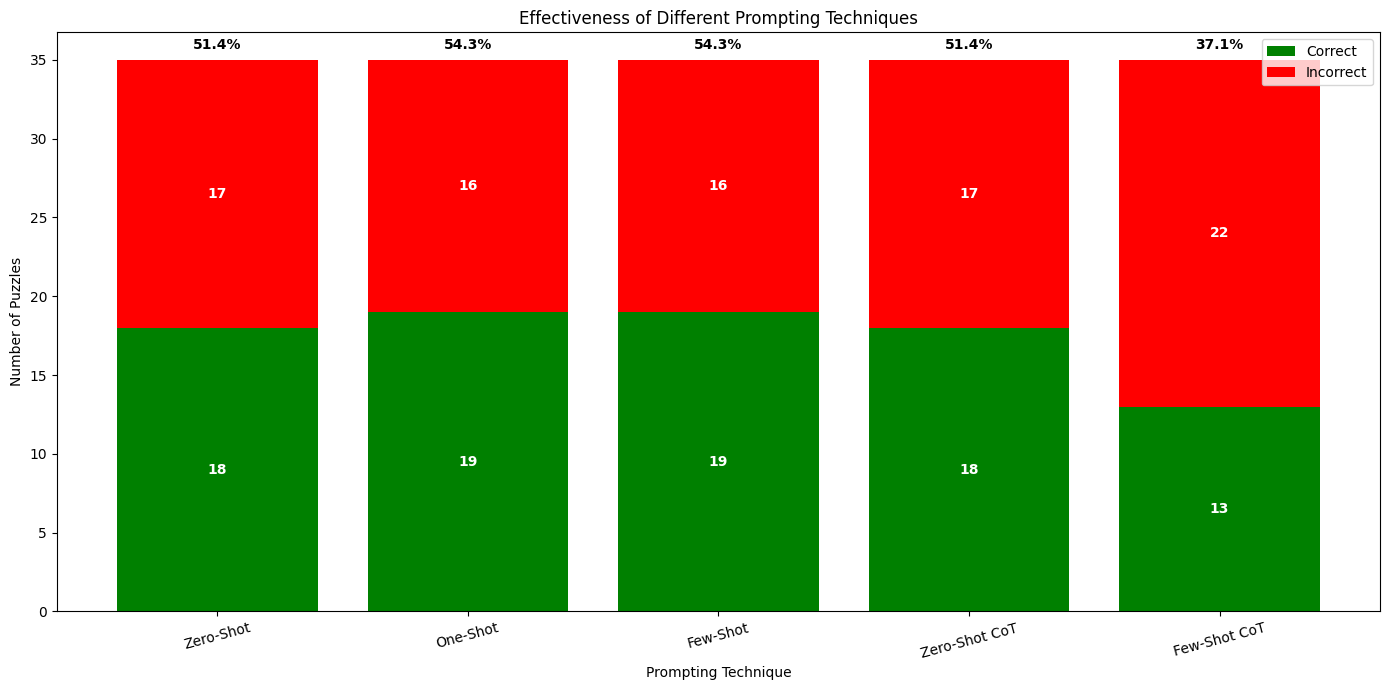

Overall accuracy: 49.71% (87/175)

Accuracy by difficulty level:
  easy: 65.88% (56/85)
  medium: 35.00% (21/60)
  hard: 33.33% (10/30)


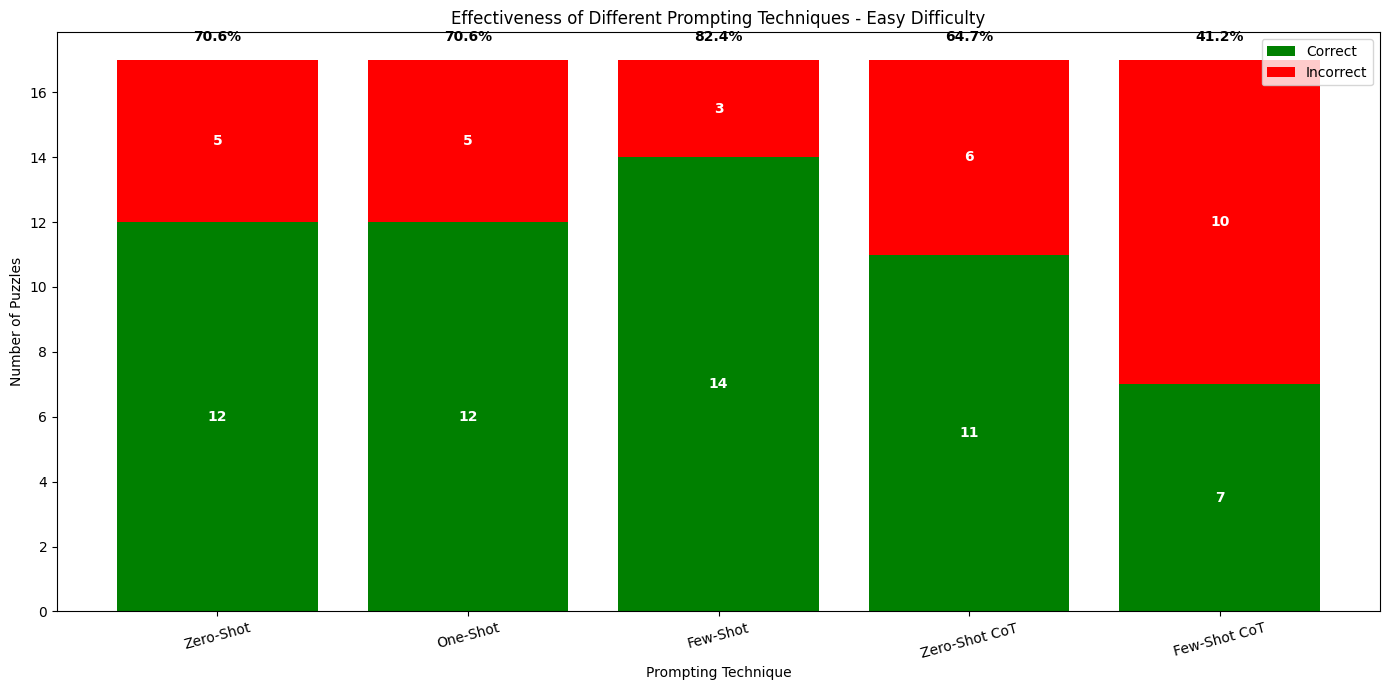

Overall accuracy: 65.88% (56/85)


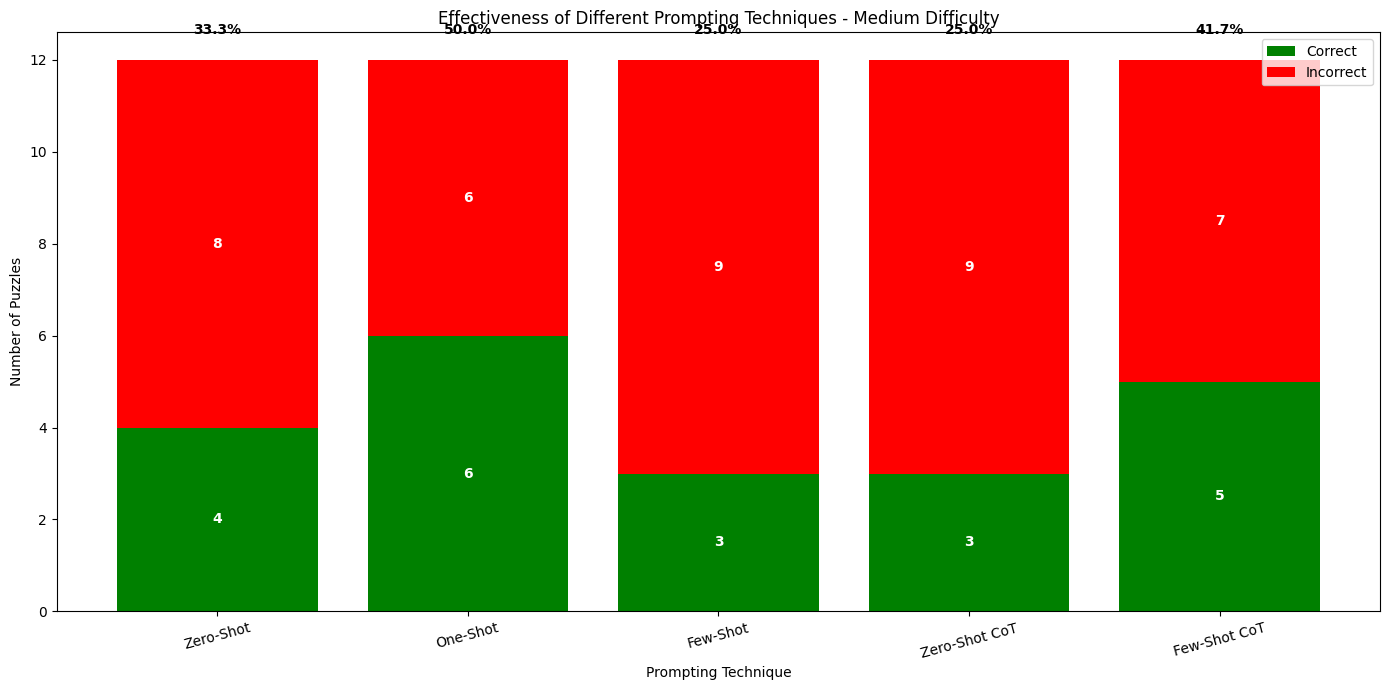

Overall accuracy: 35.00% (21/60)


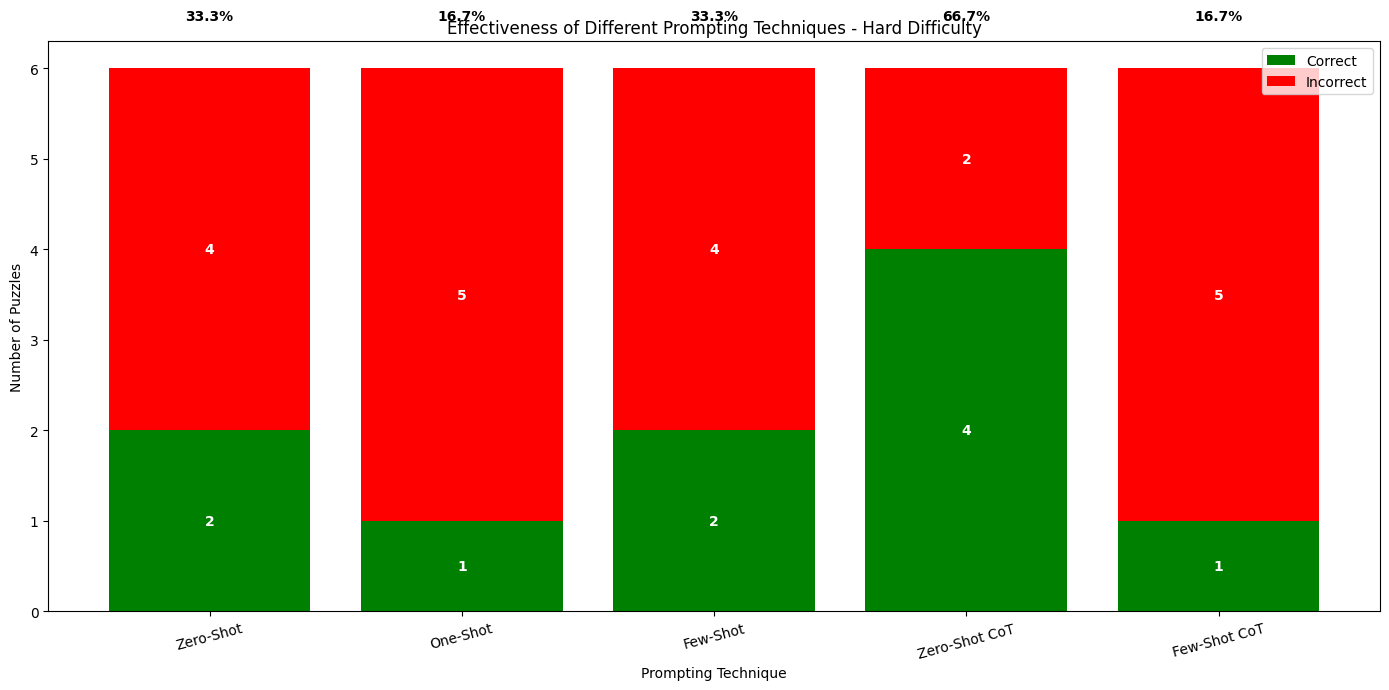

Overall accuracy: 33.33% (10/30)

===== EVALUATION EXAMPLES =====

✅ CORRECT EXAMPLES (2 of 87):

Puzzle: Pięć osób zje 5 kanapek w 5 minut. Ile kanapek 1 osoba w 5 minut?
Strategy: Few-Shot CoT
Ground truth: 1
Model answer: 1. Analizujemy problem: W pokoju jest pięć osób, a każda z nich jeden raz zjeła kanapkę w czasie 5 minut. Proszę wyobrazić sobie, że wszyscy jedzą tę samą ilość i tę samą ilość czasu potrzebują na jeść.

  2. Rozbijemy problem na mniejsze kroki: Jaką ilość kanapek jest spożyta przez pojedynczą osobę w ciągu 5 minut?

  3. Rozwiązujemy każdy krok osobno: Ilość kanapek, które zjadła jedna osoba w czasie 5 minut wynosi jeden (ponieważ jest to jej część całej ilości kanapek spożytych przez pięcioro osób).

  4. Wyciągamy ostateczny wniosek: Więc jedna osoba zjada jedną kanapkę w ciągu 5 minut, dlatego całkowitym wynikiem jest odpowiedź: 'Odpowiedź: 1'.
Evaluation: CORRECT
--------------------------------------------------

Puzzle: Stół ma 4 nogi. 5 stołów ile nóg?
Stra

In [55]:
print("\nRunning two-phase evaluation with OpenAI as judge...")

import os

results = run_full_evaluation_workflow(
    puzzles_df,
    tokenizer, 
    model, 
    puzzles_embeddings,
    sample_size=None
)

In [56]:
# Load the CSV file
df = pd.read_csv('evaluated_answers.csv')

# Display the first 20 rows

incorrect_answers = df[df['evaluation'].str.contains('INCORRECT', na=False)]
print(f"Found {len(incorrect_answers)} incorrect answers")
df.head(20)

Found 88 incorrect answers


,puzzle_id,puzzle,ground_truth,model_answer,strategy,difficulty,evaluation,is_correct
0,0,Która większa: suma 5 i 6 czy iloczyn 2 i 6?,iloczyn,"1. Dla porządku, podajemy kolejno liczby, a na...",Zero-Shot,easy,CORRECT,True
1,0,Która większa: suma 5 i 6 czy iloczyn 2 i 6?,iloczyn,"Odpowiedź: Czyli suma 5 i 6 czy iloczyn 2 i 6,...",One-Shot,easy,CORRECT,True
2,0,Która większa: suma 5 i 6 czy iloczyn 2 i 6?,iloczyn,Odpowiedź: Iloczyn 2 i 6,Few-Shot,easy,CORRECT,True
3,0,Która większa: suma 5 i 6 czy iloczyn 2 i 6?,iloczyn,1. Przejrzyjemy problem dokładnie:\n - Pod...,Zero-Shot CoT,easy,CORRECT,True
4,0,Która większa: suma 5 i 6 czy iloczyn 2 i 6?,iloczyn,1. Analizujemy problem: Zadana jest prosta zag...,Few-Shot CoT,easy,INCORRECT,True
5,1,Kamil nie wygrał. Marta lepsza niż Patryk. Kto...,Marta,Odpowiedź: Marta,Zero-Shot,medium,CORRECT,True
6,1,Kamil nie wygrał. Marta lepsza niż Patryk. Kto...,Marta,"Odpowiedź: Kamil nie wygrał, ponieważ został w...",One-Shot,medium,INCORRECT,True
7,1,Kamil nie wygrał. Marta lepsza niż Patryk. Kto...,Marta,Odpowiedź: Nie ma możliwości ustalenia odpowie...,Few-Shot,medium,INCORRECT,True
8,1,Kamil nie wygrał. Marta lepsza niż Patryk. Kto...,Marta,1. Analizujemy problem:\n - Kamil nie wygr...,Zero-Shot CoT,medium,CORRECT,True
9,1,Kamil nie wygrał. Marta lepsza niż Patryk. Kto...,Marta,1. Analiza problemu: Zadana jest relacja porów...,Few-Shot CoT,medium,CORRECT,True
